In [1]:
import pandas as pd
import seaborn as sns
import glob
import os
import numpy as np
import re

In [2]:
def get_mins(time_str):
    if not pd.isnull(time_str):
        if time_str.count(":")==2:
            """Get minutes from time."""
            h, m, s = time_str.split(':')
            total_time = (int(h) * 3600 + int(m) * 60 + float(s))/60
        elif time_str.count(":")==1:
            """Get minutes from time."""
            m, s = time_str.split(':')
            total_time = (int(m) * 60 + float(s))/60
        
        return total_time
    
def get_foldersize(row):
    if row["unit"] == 'G':
        return row['size']
    elif row['unit'] == 'M':
        return row['size'] / 1024
    elif row['unit'] == 'K':
        return row['size'] / (1024 * 1024)
    
def get_filesize(row):
    if row["task"] in ['multiqc','fastqc','trimgalore','matchingcontigsreads']:
        return row['foldersize_gb']
    else:
        return assembly_stats[(assembly_stats.mgnifyID == row.mgnifyID) & (assembly_stats.task == 'merge')]['foldersize_gb'].values[0]

In [3]:
assembly_stats = pd.DataFrame()
folder = os.path.expanduser('~/OneDrive - The University of Melbourne/Documents/MDAP/Verbruggen/outputs/')
for o in os.listdir(folder):
    files = glob.glob(folder + "/" + o + "/optimisation/*.txt")
    for file in files:
        parts = file.split("\\")[-1].split(".txt")[0].split("_")
        tmp = ''.join(map(str, parts[2:])).replace('task','').split('.')
        task = tmp[0]
        tempsize = re.findall(r'(.*\d+?)(\w+)', '.'.join(map(str, tmp[1:])))[0]
        size = float(tempsize[0])
        unit = tempsize[1]

        with open(file, 'rt') as fd:
            next(fd)
            lines = [line.strip().split(': ') for line in fd]

            temp = pd.DataFrame({line[0]: line[1] for line in lines if len(line)==2}, index=[0])
            temp.insert(0, 'mgnifyID', o)
            temp.insert(1, 'task', task)
            temp.insert(2, 'size', size)
            temp.insert(3, 'unit', unit)
            assembly_stats = pd.concat([assembly_stats, temp], ignore_index=True)
            
assembly_stats.drop(['Average shared text size (kbytes)','Swaps','Socket messages sent','File system inputs',
                     'Socket messages received','Average resident set size (kbytes)','Major (requiring I/O) page faults',
                     'Signals delivered','Page size (bytes)','Average unshared data size (kbytes)',
                     'Average stack size (kbytes)','Average total size (kbytes)','Exit status','User time (seconds)',
                     'System time (seconds)','Minor (reclaiming a frame) page faults','Voluntary context switches',
                     'Involuntary context switches','File system outputs'], axis=1, inplace=True)

In [4]:
assembly_stats

,mgnifyID,task,size,unit,Percent of CPU this job got,Elapsed (wall clock) time (h:mm:ss or m:ss),Maximum resident set size (kbytes)
0,MGYS00001246_0_outputs,hmmerMergedTaxon,3.0,G,100%,44:43.10,10938760
1,MGYS00001246_0_outputs,matchingcontigsreads,2.0,G,68%,0:00.19,18336
2,MGYS00001246_0_outputs,merge,8.8,G,90%,0:03.24,22832
3,MGYS00001246_0_outputs,multiqc,5.0,M,38%,0:07.53,98260
4,MGYS00001246_0_outputs,readalignment,2.0,G,261%,53:33.18,3870280
...,...,...,...,...,...,...,...
68,SRP044024_0_outputs,prodigal,37.0,M,100%,2:41.77,58824
69,SRP044024_0_outputs,fastqc,160.0,M,197%,0:10.70,841764
70,SRP044024_0_outputs,trimgalore,208.0,M,256%,1:02.62,115156
71,SRP044024_0_outputs,fastqc,176.0,M,194%,0:11.66,850460


In [5]:
assembly_stats['time (minutes)'] = assembly_stats['Elapsed (wall clock) time (h:mm:ss or m:ss)'].apply(get_mins)

assembly_stats['cpu'] = assembly_stats['Percent of CPU this job got'].str.replace('%','')

numeric_cols = ['cpu','Maximum resident set size (kbytes)', 'size']
assembly_stats[numeric_cols] = assembly_stats[numeric_cols].apply(pd.to_numeric, errors='coerce', axis=1)

assembly_stats['max_memory_gb'] = np.ceil(assembly_stats['Maximum resident set size (kbytes)'].divide(1048576))

assembly_stats['foldersize_gb'] = assembly_stats.apply(get_foldersize, axis=1)

assembly_stats['filesize_gb'] = assembly_stats.apply(get_filesize, axis=1)

assembly_stats

,mgnifyID,task,size,unit,Percent of CPU this job got,Elapsed (wall clock) time (h:mm:ss or m:ss),Maximum resident set size (kbytes),time (minutes),cpu,max_memory_gb,foldersize_gb,filesize_gb
0,MGYS00001246_0_outputs,hmmerMergedTaxon,3.0,G,100%,44:43.10,10938760.0,44.718333,100.0,11.0,3.000000,8.800000
1,MGYS00001246_0_outputs,matchingcontigsreads,2.0,G,68%,0:00.19,18336.0,0.003167,68.0,1.0,2.000000,2.000000
2,MGYS00001246_0_outputs,merge,8.8,G,90%,0:03.24,22832.0,0.054000,90.0,1.0,8.800000,8.800000
3,MGYS00001246_0_outputs,multiqc,5.0,M,38%,0:07.53,98260.0,0.125500,38.0,1.0,0.004883,0.004883
4,MGYS00001246_0_outputs,readalignment,2.0,G,261%,53:33.18,3870280.0,53.553000,261.0,4.0,2.000000,8.800000
...,...,...,...,...,...,...,...,...,...,...,...,...
68,SRP044024_0_outputs,prodigal,37.0,M,100%,2:41.77,58824.0,2.696167,100.0,1.0,0.036133,1.100000
69,SRP044024_0_outputs,fastqc,160.0,M,197%,0:10.70,841764.0,0.178333,197.0,1.0,0.156250,0.156250
70,SRP044024_0_outputs,trimgalore,208.0,M,256%,1:02.62,115156.0,1.043667,256.0,1.0,0.203125,0.203125
71,SRP044024_0_outputs,fastqc,176.0,M,194%,0:11.66,850460.0,0.194333,194.0,1.0,0.171875,0.171875


In [6]:
data = pd.melt(assembly_stats, id_vars=['mgnifyID','task','filesize_gb','foldersize_gb'], value_vars=['time (minutes)','max_memory_gb','cpu'])

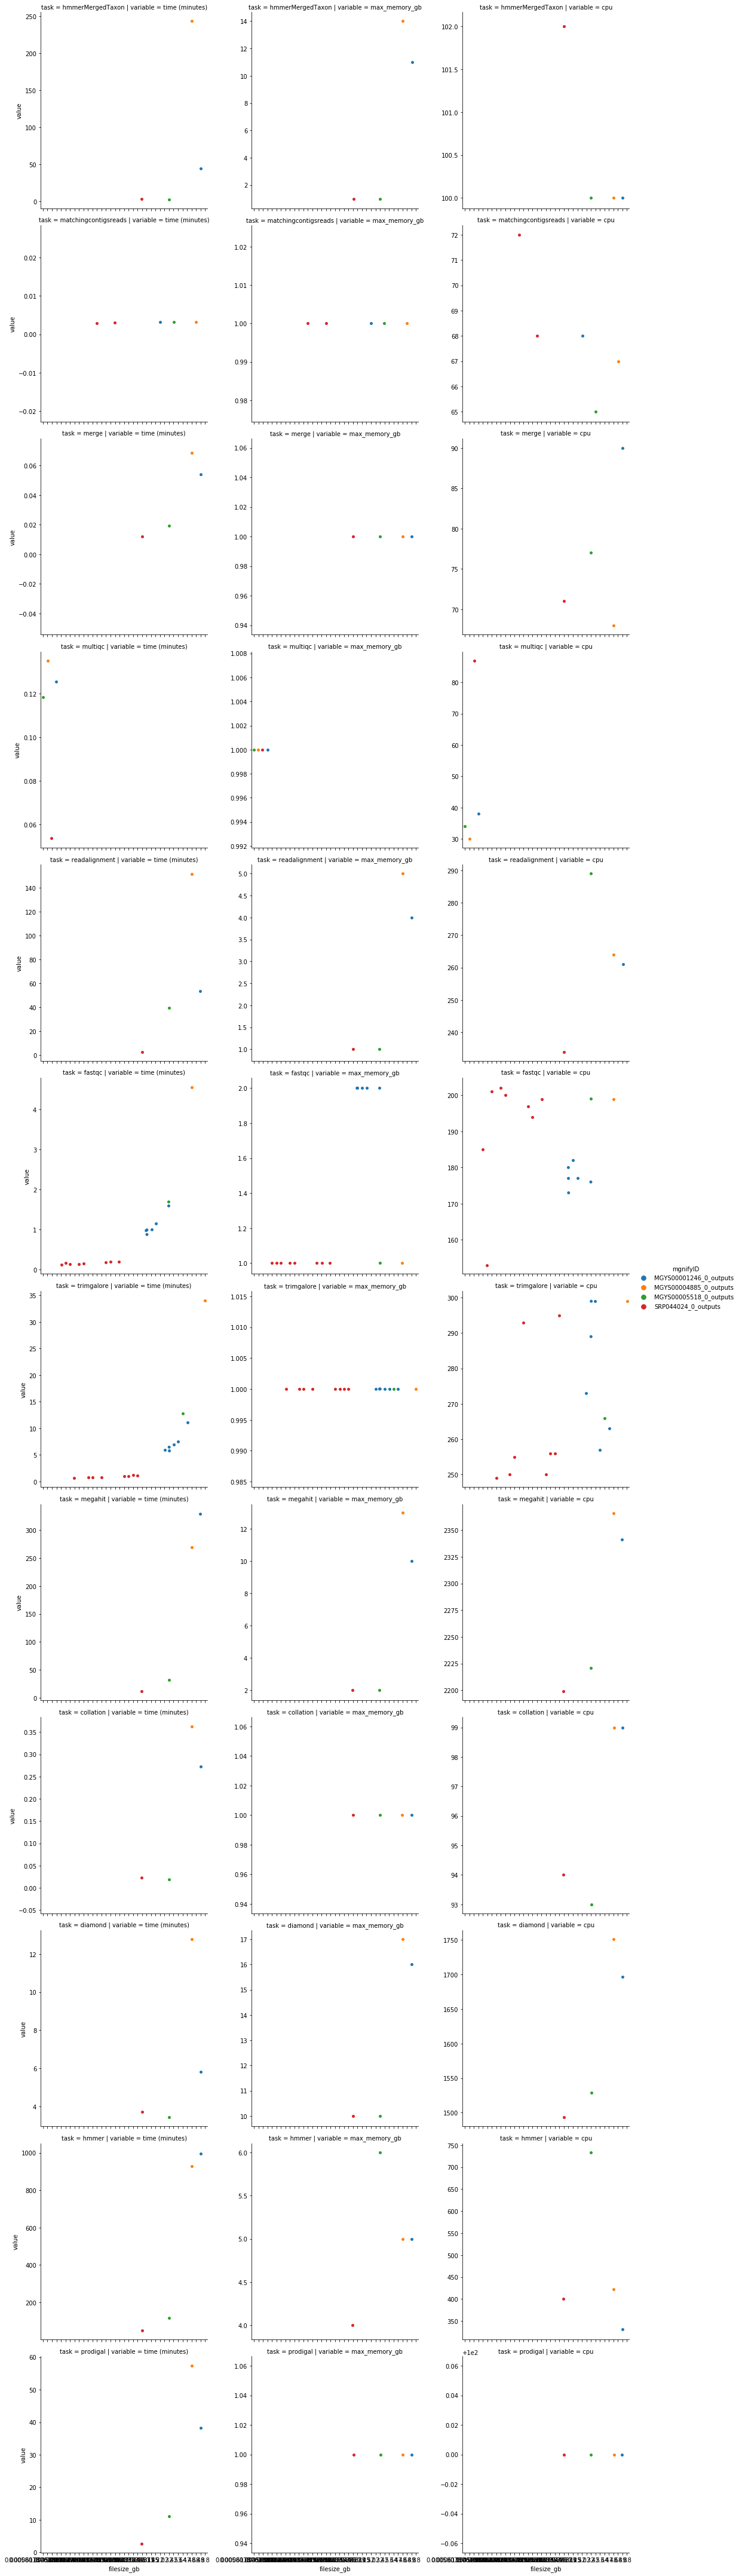

In [9]:
sns.catplot(x="filesize_gb", y="value", row='task', col='variable', hue='mgnifyID', data=data, sharey=False)